# Importing Libraries

In [1]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import os
import glob
from PIL import Image
import h5py
import cv2
import time
import json

# Function Defintion

In [2]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    im = np.array(im)
    ### Need to give credits to the original author who suggested this image transformation
    im = im/255.0
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225
    return im

def get_input(path):
    img = create_img(path)
    return(img)
    
def get_output(path):
    gt_file = h5py.File(path,'r')
    target = np.asarray(gt_file['density'])
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64 ### why shrink the size of the ground truth ???
    return img

def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

# Mounting Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')
root = 'drive/My Drive/Downloads/data'

Mounted at /content/drive


# Loading Dataset Paths -- this

In [4]:
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
temp = 'test_images'
path_sets = [part_A_train] # analysis -- > separately train on A, B and then AB

In [5]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(str(img_path))
print("Total images : ",len(img_paths))

Total images :  300


In [6]:
train_paths,val_paths = train_test_split(img_paths, test_size=0.2)

# Model Definition -- this

Use fontend only when we want to use standard models
if not... comment out all the lines related to frontend and define own (custom) model using backend

## CSRNet - VGG

In [8]:
class VGG_CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(VGG_CSRNet, self).__init__()
        vgg = models.vgg16_bn(pretrained=True)
        #alex = models.alexnet(pretrained=True)
        #res = models.resnext50_32x4d(pretrained=True)

        #self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        #self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1) # 1X1 convolution
        #self._initialize_weights()
        self.frontend = vgg.features[:37]
        #self.frontend = alex.features[:?]
        #self.frontend = res.features[:?]
        for param in self.frontend.parameters():
          param.requires_grad = False
        for param in self.backend.parameters():
          param.requires_grad = True
        for param in self.output_layer.parameters():
          param.requires_grad = True
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## CSRNet - SqueezeNet

In [ ]:
squeezenet

In [ ]:
class Squeeze_CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(Squeeze_CSRNet, self).__init__()
        #vgg = models.vgg16_bn(pretrained=True)
        #alex = models.alexnet(pretrained=True)
        #res = models.resnext50_32x4d(pretrained=True)
        squeezenet = models.squeezenet1_0()
        #self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [128,128,64]
        #self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 128,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1) # 1X1 convolution
        #self._initialize_weights()
        #self.frontend = vgg.features[:37]
        #self.frontend = alex.features[:5]
        #self.frontend = res.features
        self.frontend = squeezenet.features[:4]
        for param in self.frontend.parameters():
          param.requires_grad = False
        for param in self.backend.parameters():
          param.requires_grad = True
        for param in self.output_layer.parameters():
          param.requires_grad = True
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## CSRNet - MobileNet V1

In [ ]:
mobilenet = models.mobilenet_v2()
mobilenet

In [ ]:
class Mobile_CSRNet_V1(nn.Module):
    def __init__(self, load_weights=False):
        super(Mobile_CSRNet_V1, self).__init__()
        mobilenet = models.mobilenet_v2()
        in_ch = 24 # input channels to backend
        self.backend_feat  = [in_ch,24,12]
        self.backend = make_layers(self.backend_feat,in_channels = in_ch,dilation = True)
        self.output_layer = nn.Conv2d(12, 1, kernel_size=1) # 1X1 convolution
        self.frontend = mobilenet.features[:4]
        for param in self.frontend.parameters():
          param.requires_grad = False
        for param in self.backend.parameters():
          param.requires_grad = True
        for param in self.output_layer.parameters():
          param.requires_grad = True
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## CSRNet - MobileNet V2

Includes a ReLU activation at the output node to avoid negative values -- failed

In [ ]:
class Mobile_CSRNet_V2(nn.Module):
    def __init__(self, load_weights=False):
        super(Mobile_CSRNet_V2, self).__init__()
        mobilenet = models.mobilenet_v2()
        in_ch = 24 # input channels to backend
        self.backend_feat  = [in_ch,24,12]
        self.backend = make_layers(self.backend_feat,in_channels = in_ch,dilation = True)
        self.output_layer = nn.Sequential(
            nn.Conv2d(12, 1, kernel_size=1),
            nn.ReLU()
        )
        self.frontend = mobilenet.features[:4]
        for param in self.frontend.parameters():
          param.requires_grad = False
        for param in self.backend.parameters():
          param.requires_grad = True
        for param in self.output_layer.parameters():
          param.requires_grad = True
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## CSRNet - MobileNet V3

yet to be tried

In [ ]:
class Mobile_CSRNet_V3(nn.Module):
    def __init__(self, load_weights=False):
        super(Mobile_CSRNet_V3, self).__init__()
        mobilenet = models.mobilenet_v2()
        in_ch = 24 # input channels to backend
        self.backend_feat  = [in_ch,24,12]
        self.backend = make_layers(self.backend_feat,in_channels = in_ch,dilation = True)
        self.output_layer = nn.Conv2d(12, 1, kernel_size=1)
        self.frontend = mobilenet.features[:4]
        for param in self.frontend.parameters():
          param.requires_grad = False
        for param in self.backend.parameters():
          param.requires_grad = True
        for param in self.output_layer.parameters():
          param.requires_grad = True
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return torch.abs(x)
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## CSRNet - DenseNet 

In [ ]:
densenet = models.densenet161()
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
class Dense_CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(Dense_CSRNet, self).__init__()
        densenet = models.densenet161()
        in_ch = 2208 # input channels to backend
        self.backend_feat  = [in_ch,24,12]
        self.backend = make_layers(self.backend_feat,in_channels = in_ch,dilation = True)
        self.output_layer = nn.Conv2d(12, 1, kernel_size=1)
        self.frontend = densenet.features
        for param in self.frontend.parameters():
          param.requires_grad = False
        for param in self.backend.parameters():
          param.requires_grad = True
        for param in self.output_layer.parameters():
          param.requires_grad = True
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return torch.abs(x)
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## CSRNet - ShuffleNet

In [ ]:
shufflenet = models.shufflenet_v2_x1_0()
shufflenet

In [ ]:
class Shuffle_CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(Shuffle_CSRNet, self).__init__()
        shufflenet = models.shufflenet_v2_x1_0()
        in_ch = 116 # input channels to backend
        self.backend_feat  = [in_ch,29,29]
        self.backend = make_layers(self.backend_feat,in_channels = in_ch,dilation = True)
        self.output_layer = nn.Conv2d(29, 1, kernel_size=1) # 1X1 convolution
        self.frontend1 = shufflenet.conv1
        self.frontend2 = shufflenet.maxpool
        self.frontend3 = shufflenet.stage2
        for param in self.frontend1.parameters():
          param.requires_grad = False
        for param in self.frontend2.parameters():
          param.requires_grad = False
        for param in self.frontend3.parameters():
          param.requires_grad = False
        for param in self.backend.parameters():
          param.requires_grad = True
        for param in self.output_layer.parameters():
          param.requires_grad = True
    def forward(self,x):
        x = self.frontend1(x)
        x = self.frontend2(x)
        x = self.frontend3(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## Alexnet

In [ ]:
class AlexNet(nn.Module):

  def __init__(self, num_classes=10):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5)), # (N, 3, 227, 227) -> (N, 64, 227, 227)
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), # (N, 64, 56, 56) -> (N, 64, 27, 27)
        
        nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), # (N, 64, 27, 27) -> (N, 192, 27, 27)
        nn.ReLU(inplace=True), 
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False), # (N, 192, 27, 27) -> (N, 192, 13, 13)

        nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # (N, 192, 13, 13) -> (N, 384, 13, 13)
        nn.ReLU(inplace=True), 
        nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # (N, 384, 13, 13) -> (N, 256, 13, 13)
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # (N, 256, 13, 13) -> (N, 256, 13, 13)
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False), # (N, 256, 13, 13) -> (N, 256, 6, 6) 
        nn.Conv2d(256,1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # (N, 256, 13, 13) -> (N, 256, 13, 13)
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    x = self.features(x)
    return x

## LeNet

In [ ]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=(5,5), padding=2), # (3,m,n) -> (6,m,n)
            nn.Sigmoid(),
            nn.AvgPool2d(3, padding = 1, stride=1), # (6,m,n) -> (6,m,n)
            nn.Conv2d(6, 16, kernel_size=(5,5), padding=2), # (6,m,n) -> (16,m,n)
            nn.Sigmoid(),
            nn.AvgPool2d(3, padding = 1, stride=1), # (13,m,n) -> (16,m,n)
            nn.Conv2d(16, 1, kernel_size=(1,1), padding=0), # (16,m,n) -> (1,m,n)
            nn.ReLU(),
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        return x

# Porting to GPU

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#model = LeNet().to(device)
#model = AlexNet().to(device)
model = VGG_CSRNet().to(device) 
#model = Squeeze_CSRNet().to(device)
#model = Mobile_CSRNet_V1().to(device) # pb: negative counts
#model = Shuffle_CSRNet().to(device) 
#model = Mobile_CSRNet_V2().to(device)  # pb: DEAD NEURONS
#model = Dense_CSRNet().to(device) 
loss_fn = nn.MSELoss() 
#loss_fn = nn.L1Loss() # mae loss
opt = optim.Adam(model.parameters())

cuda:0


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


# Training

In [10]:
save_immediately = True
load_prev_model = False # True if want to load previously trained model and want to retrain for few more epochs

In [ ]:
#model = CSRNet()
#if(load_prev_model):  
#  model.load_state_dict(torch.load("/content/CSRNet.txt")) 
#model = model.to(device)
  #model.eval()
trainloader = torch.utils.data.DataLoader(train_paths, batch_size=1, shuffle=True)
valloader = torch.utils.data.DataLoader(val_paths, batch_size=1, shuffle=True)
max_epochs = 100

train_loss = []
val_loss = []

for epoch in range(max_epochs):
  tic = time.time()
  tmp = []
  
  for i, data in enumerate(trainloader, 0):
    inputt = get_input(data[0])
    inputt = np.transpose(inputt, (2,0,1))
    inputt = inputt.reshape(1,inputt.shape[0],inputt.shape[1],inputt.shape[2])
    inputt = torch.tensor(inputt).float()
    ground_truth = torch.tensor(get_output(data[0].replace('.jpg','.h5').replace('images','ground')) )
    inputt, ground_truth = inputt.to(device), ground_truth.to(device)
    opt.zero_grad()
    model_output = model(inputt) # <-
    loss = loss_fn(torch.sum(model_output), torch.sum(ground_truth))
    loss.backward()
    opt.step()
    tmp.append(loss.item())
  train_loss.append(np.mean(tmp))
  tmp = []
  
  for i, data in enumerate(valloader, 0):
    inputt = get_input(data[0])
    inputt = np.transpose(inputt, (2,0,1))
    inputt = inputt.reshape(1,inputt.shape[0],inputt.shape[1],inputt.shape[2])
    inputt = torch.tensor(inputt).float()
    ground_truth = torch.tensor(get_output(data[0].replace('.jpg','.h5').replace('images','ground')) )
    inputt, ground_truth = inputt.to(device), ground_truth.to(device)
    opt.zero_grad()
    model_output = model(inputt) # <-
    loss = loss_fn(torch.sum(model_output), torch.sum(ground_truth))
    tmp.append(loss.item())
  val_loss.append(np.mean(tmp))
  print(train_loss[-1], val_loss[-1])
  toc = time.time()
  print("Time taken: {}".format(np.round(toc-tic,3)))
  print('Epoch: %d/%d' % (epoch+1, max_epochs))

if(save_immediately):
  torch.save(model.state_dict(),"/content/CSRNet.txt")

# Loss curve and Performance metrics

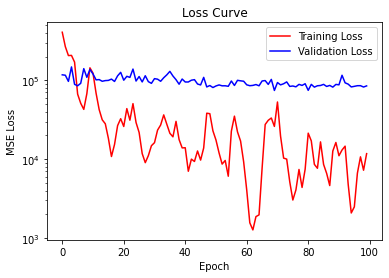

In [ ]:
plt.semilogy(train_loss,'r',label='Training Loss')
plt.semilogy(val_loss,'b',label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Loss Curve")
plt.savefig("vgg_csrnet_v2_loss_curve_100A_MSE_Adam.png",bbox_inches = "tight")

# Saving trained model

In [ ]:
print(train_loss[-1], np.amin(train_loss))
torch.save(model.state_dict(),"/content/CSRNet.txt")

175196.81204685976 174401.7068522789


# Sample - Misc

In [ ]:
inputt = get_input(img_paths[0])
inputt = np.transpose(inputt, (2,0,1))
inputt = inputt.reshape(1,inputt.shape[0],inputt.shape[1],inputt.shape[2])
inputt = torch.tensor(inputt).float()
ground_truth = torch.tensor(get_output(img_paths[0].replace('.jpg','.h5').replace('images','ground')))
inputt, ground_truth = inputt.to(device), ground_truth.to(device)
model_output = model(inputt)
model_output = model_output.to('cpu').detach().numpy()
ground_truth = ground_truth.to('cpu').numpy()

In [ ]:
np.sum(model_output[0][0]), np.sum(ground_truth)

(626.13464, 864.5715)

In [ ]:
np.amin(model_output[0][0])

0.28151828

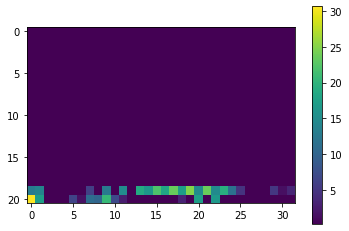

In [ ]:
plt.imshow(model_output[0][0])
plt.colorbar()

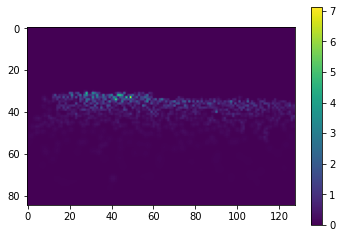

In [ ]:
plt.imshow(ground_truth)
plt.colorbar()

# Saving Model outputs to .npy files

In [ ]:
if(not os.path.isdir("/content/model_density_maps/")):
  os.mkdir("/content/model_density_maps/")
  model_hmap_paths = "/content/model_density_maps/"
model_hmap_sum = []
gt_sum = []
for i, data in enumerate(img_paths, 0):
  inputt = get_input(data)
  inputt = np.transpose(inputt, (2,0,1))
  inputt = inputt.reshape(1,inputt.shape[0],inputt.shape[1],inputt.shape[2])
  inputt = torch.tensor(inputt).float()
  inputt = inputt.to(device)
  gt_sum.append([data,float(np.sum(get_output(data.replace('.jpg','.h5').replace('images','ground'))))])
  model_output = model(inputt)
  model_output = model_output.to('cpu').detach().numpy()
  model_hmap_sum.append([data,float(np.sum(model_output))])
  f_name = data.split('/')[-1]
  f_name = f_name.split('.')
  f_name = f_name[0]+'_model_density_map.npy'
  np.save("/content/model_density_maps/{}".format(f_name), model_output)
with open('/content/model_density_maps/model_hmap_sum.json', 'w') as f:
  json.dump(model_hmap_sum, f)
with open('/content/model_density_maps/gt_sum.json', 'w') as f:
  json.dump(gt_sum, f)

In [ ]:
!zip -r /content/shuffle_csrnet_dmap.zip /content/model_density_maps
from google.colab import files
files.download("/content/shuffle_csrnet_dmap.zip")

  adding: content/model_density_maps/ (stored 0%)
  adding: content/model_density_maps/IMG_289_model_density_map.npy (deflated 95%)
  adding: content/model_density_maps/IMG_245_model_density_map.npy (deflated 95%)
  adding: content/model_density_maps/IMG_202_model_density_map.npy (deflated 93%)
  adding: content/model_density_maps/IMG_30_model_density_map.npy (deflated 92%)
  adding: content/model_density_maps/IMG_247_model_density_map.npy (deflated 95%)
  adding: content/model_density_maps/IMG_186_model_density_map.npy (deflated 82%)
  adding: content/model_density_maps/model_hmap_sum.json (deflated 88%)
  adding: content/model_density_maps/IMG_44_model_density_map.npy (deflated 96%)
  adding: content/model_density_maps/IMG_269_model_density_map.npy (deflated 88%)
  adding: content/model_density_maps/IMG_55_model_density_map.npy (deflated 93%)
  adding: content/model_density_maps/IMG_244_model_density_map.npy (deflated 87%)
  adding: content/model_density_maps/IMG_39_model_density_map

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Regressor

## CSRNet_vgg

In [ ]:
class CSRNet_regressor(nn.Module):
    def __init__(self): 
        super(CSRNet_regressor, self).__init__()
        self.fc_model = nn.Sequential(
            nn.Linear(1,10),         
            nn.ReLU(),
            nn.Linear(10,25),
            nn.ReLU(),
            nn.Linear(25,1)
        )

    def forward(self, x):
        x = self.fc_model(x)
        return x

## Squeeze CSRNet

In [ ]:
class Squeeze_CSRNet_regressor(nn.Module):
    def __init__(self): 
        super(Squeeze_CSRNet_regressor, self).__init__()
        self.fc_model = nn.Sequential(
            nn.Linear(1,10),         
            nn.ReLU(),
            nn.Linear(10,25),
            nn.ReLU(),
            nn.Linear(25,1)
        )

    def forward(self, x):
        x = self.fc_model(x)
        return x

## Mobile CSRNet

In [ ]:
class Mobile_CSRNet_regressor(nn.Module):
    def __init__(self): 
        super(Mobile_CSRNet_regressor, self).__init__()
        self.fc_model = nn.Sequential(
            nn.Linear(1,10),         
            nn.ReLU(),
            nn.Linear(10,25),
            nn.ReLU(),
            nn.Linear(25,1)
        )

    def forward(self, x):
        x = self.fc_model(x)
        return x

##  Shuffle CSRNet

In [ ]:
class Shuffle_CSRNet_regressor(nn.Module):
    def __init__(self): 
        super(Shuffle_CSRNet_regressor, self).__init__()
        self.fc_model = nn.Sequential(
            nn.Linear(1,10),         
            nn.ReLU(),
            nn.Linear(10,25),
            nn.ReLU(),
            nn.Linear(25,1)
        )

    def forward(self, x):
        x = self.fc_model(x)
        return x

## Dense CSRNet

In [ ]:
class Dense_CSRNet_regressor(nn.Module):
    def __init__(self): 
        super(Dense_CSRNet_regressor, self).__init__()
        self.fc_model = nn.Sequential(
            nn.Linear(1,10),         
            nn.ReLU(),
            nn.Linear(10,25),
            nn.ReLU(),
            nn.Linear(25,1)
        )

    def forward(self, x):
        x = self.fc_model(x)
        return x

In [ ]:
f = open('/content/model_density_maps/model_hmap_sum.json',) 
model_hmap_sum = json.load(f)
regdata = np.array([row[-1] for row in model_hmap_sum]).reshape(-1,1)
f = open('/content/model_density_maps/gt_sum.json',) 
gt_sum = json.load(f)
gtsum = np.array([row[-1] for row in gt_sum]).reshape(-1,1)

In [ ]:
regdata = torch.tensor(regdata).float().to(device)
gtsum = torch.tensor(gtsum).float().to(device)

In [ ]:
model_hmap_paths = "/content/model_density_maps/"
regloader = torch.utils.data.DataLoader(model_hmap_paths, batch_size=1, shuffle=True)
#regnet = CSRNet_regressor().to(device)
regnet = Dense_CSRNet_regressor().to(device)
loss_fn = nn.MSELoss()
opt = optim.Adam(regnet.parameters())

In [ ]:
max_epochs = 1000
train_loss = []
train_acc_arr = []

for epoch in range(max_epochs):
  opt.zero_grad()
  model_output = regnet(regdata)
  loss = loss_fn(model_output, gtsum)
  loss.backward()
  opt.step()
  train_loss.append(loss.item())
  #print('Epoch: %d/%d' % (epoch, max_epochs))

In [ ]:
regdata[0], regnet(regdata[0]), gtsum[0]

(tensor([626.1346], device='cuda:0'),
 tensor([638.0694], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([864.5715], device='cuda:0'))

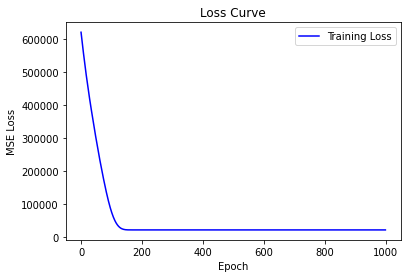

In [ ]:
plt.plot(train_loss,'b',label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Loss Curve")
plt.savefig("Dense_CSRNet_regressor_loss_curve_100epochs.png",bbox_inches = "tight")

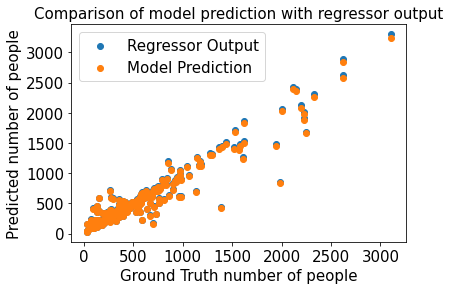

In [ ]:
model_sum = regnet(regdata).detach().cpu().numpy()
gt_sum = gtsum.cpu().numpy()
reg_data = regdata.cpu().numpy()
plt.scatter(gt_sum,model_sum, label="Regressor Output")
plt.scatter(gt_sum,reg_data, label="Model Prediction")
plt.xlabel("Ground Truth number of people",fontsize=15)
plt.ylabel("Predicted number of people",fontsize=15)
plt.legend(fontsize=15)
plt.title("Comparison of model prediction with regressor output",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("comparison.png", bbox_inches="tight")